<a href="https://colab.research.google.com/github/take2rohit/denoising_autoencoder/blob/master/colab_denoising_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
__author__ = "Rohit Lal"
__copyright__ = "Copyright (C) 2020 Rohit Lal"
__license__ = "MIT"
__version__ = "1.0"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/take2rohit/denoising_autoencoder.git

Cloning into 'denoising_autoencoder'...
remote: Enumerating objects: 5139, done.
remote: Counting objects: 100% (5139/5139), done.
remote: Compressing objects: 100% (5101/5101), done.
remote: Total 5139 (delta 61), reused 5110 (delta 34), pack-reused 0
Receiving objects: 100% (5139/5139), 47.93 MiB | 10.33 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [ ]:
!mv denoising_autoencoder/* /content/

In [ ]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
from DAE_dataset_helper import ToTensor,Resize, Normalize
from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Divide Dataset into train and test

In [ ]:
train_batch_size = 8
test_batch_size = 8
split_percent = 0.8

origami_dataset_dir = "/content/MarowDataset"
inp='Input'
out='Output'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)), Normalize(),ToTensor()])
origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)

train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=True,**kwargs)

# Check your Dataset 
## Remeber the below cell consumes precious GPU if used in notebook. 
Its better not run this part when u r planning to train

Input to network


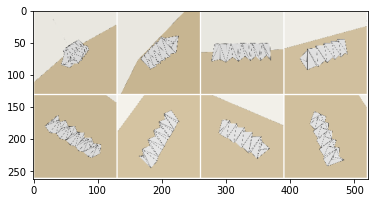

Output of network (To be verified with)


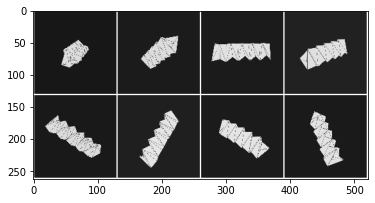

In [ ]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

# Functions of training and testing of model

In [ ]:
def train(model, device, train_loader, optimizer, epoch,log_interval=20):
    model.train()
    l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l2(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))
    scheduler.step()

def test(model, device, test_loader,save_img=False,ep=None,save_folder=None):
    model.eval()
    l2 = nn.MSELoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l2(output,target) # sum up batch loss
    test_loss /= max(1,c)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

    if save_img:
        kwargs =  {'nrow':4, "padding":2, "pad_value":1}
        images_show = 8
        op = output[:images_show,:].cpu()
        # torchvision.utils.save_image(op,f'{ep}_re.png', **kwargs)
        tar = data[:images_show,:].cpu()
        # torchvision.utils.save_image(tar, f'{ep}_in.png',**kwargs)
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder, f'{ep}_in.png'),**kwargs)
        print('image saved')

# Start Training Here

In [ ]:
epochs = 100
save_model = True
load_model = False
saved_pth = '/content/drive/My Drive/projects/origami/AE.pt'
save_intermediate_im_folder = '/content/drive/My Drive/projects/origami/trained_results'
model = AugmentedAutoencoder().to(device)

if os.path.exists(saved_pth) and load_model:
    model.load_state_dict(torch.load(saved_pth))

optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

if not os.path.exists(save_intermediate_im_folder):
    os.mkdir(save_intermediate_im_folder)

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    
    if save_model and epoch%10 ==0:
        test(model, device, test_loader,save_img=True, ep = epoch, save_folder=save_intermediate_im_folder)
        torch.save(model.state_dict(), saved_pth)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 	Loss: 0.161958
Train Epoch: 1 	Loss: 0.147848
Train Epoch: 1 	Loss: 0.088019
Train Epoch: 1 	Loss: 0.045260
Train Epoch: 1 	Loss: 0.049506
Train Epoch: 1 	Loss: 0.036474
Train Epoch: 1 	Loss: 0.037820
Train Epoch: 1 	Loss: 0.040006
Train Epoch: 1 	Loss: 0.038010
Train Epoch: 1 	Loss: 0.038458
Train Epoch: 1 	Loss: 0.033326
Train Epoch: 1 	Loss: 0.037484
Train Epoch: 2 	Loss: 0.037090
Train Epoch: 2 	Loss: 0.033348
Train Epoch: 2 	Loss: 0.040049
Train Epoch: 2 	Loss: 0.035334
Train Epoch: 2 	Loss: 0.038238
Train Epoch: 2 	Loss: 0.035040
Train Epoch: 2 	Loss: 0.038172
Train Epoch: 2 	Loss: 0.036631
Train Epoch: 2 	Loss: 0.032696
Train Epoch: 2 	Loss: 0.035265
Train Epoch: 2 	Loss: 0.032006
Train Epoch: 2 	Loss: 0.027629
Train Epoch: 3 	Loss: 0.035563
Train Epoch: 3 	Loss: 0.032813
Train Epoch: 3 	Loss: 0.033131
Train Epoch: 3 	Loss: 0.030765
Train Epoch: 3 	Loss: 0.033126
Train Epoch: 3 	Loss: 0.028417
Train Epoch: 3 	Loss: 0.034444
Train Epoch: 3 	Loss: 0.034470
Train Ep

# Validate with your own Image
Just change the folder in variable `origami_test_dir`

In [ ]:
def cross_validation(model, device, test_loader,ep = None, viewer=True, save_folder =None):
    model.eval()
    test_loss = 0
    correct = 0
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        sample = sample.to(device).float()
        output = model(sample)
        encodings = model.encoder_op(sample)
        
    if viewer:
        images_show = 8
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(op,**kwargs))
            
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save_folder is not None:
        op = output[:images_show,:].cpu()
        tar = sample[:images_show,:].cpu()
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder,'validate_res.jpg'),**kwargs)
        
    return sample, output, encodings

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Reconstructed


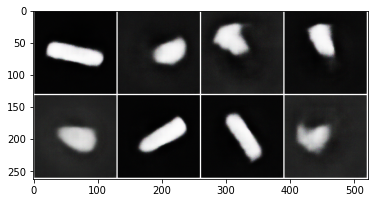

Input to Netowrk


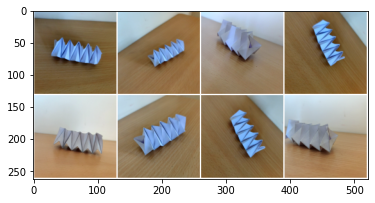

In [ ]:
origami_test_dir = "/content/MarowDataset/Test"
val_batch_size = 10

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(),ToTensorValidate() ])
validator = ValidationGenerate(root_dir=origami_test_dir, transform=trns)
val_loader = DataLoader(validator, batch_size=val_batch_size,
                            shuffle=True,**kwargs)

saved_pth = '/content/drive/My Drive/projects/origami/AE.pt'

model = AugmentedAutoencoder().to(device)
model.load_state_dict(torch.load(saved_pth))
sample, output, encodings = cross_validation(model, device, val_loader, 
                                             save_folder = '/content/drive/My Drive/projects/origami/validation_results')

In [ ]:
l2 = nn.CosineSimilarity(dim=0)

In [ ]:
n = encodings.shape[0]
z = torch.zeros((n,n))
for i in range(n):
    for j in range(n):
        z[i,j] = l2(encodings[i].squeeze(), encodings[j].squeeze())
z

tensor([[ 1.0000,  0.1685,  0.2806,  0.0590,  0.4290,  0.0377,  0.5167,  0.2334,
          0.4531,  0.4678,  0.3895,  0.5749],
        [ 0.1685,  1.0000,  0.3174,  0.4120, -0.0292,  0.4188, -0.0492,  0.0070,
         -0.1316,  0.2316,  0.4632, -0.1118],
        [ 0.2806,  0.3174,  1.0000,  0.8790,  0.3362,  0.8438,  0.5009,  0.6208,
          0.4165,  0.9064,  0.1330,  0.2157],
        [ 0.0590,  0.4120,  0.8790,  1.0000,  0.1262,  0.9553,  0.2781,  0.4138,
          0.1905,  0.6975,  0.1628, -0.0310],
        [ 0.4290, -0.0292,  0.3362,  0.1262,  1.0000,  0.0920,  0.2364,  0.4078,
          0.2060,  0.4087,  0.2400,  0.6942],
        [ 0.0377,  0.4188,  0.8438,  0.9553,  0.0920,  1.0000,  0.2155,  0.3928,
          0.1299,  0.6216,  0.1744, -0.0228],
        [ 0.5167, -0.0492,  0.5009,  0.2781,  0.2364,  0.2155,  1.0000,  0.4538,
          0.9726,  0.7541, -0.1611,  0.3630],
        [ 0.2334,  0.0070,  0.6208,  0.4138,  0.4078,  0.3928,  0.4538,  1.0000,
          0.4123,  0.6537, -0.